In [1]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Data Preparation and Feature Engineering

In [34]:
df = pd.read_excel('Online Retail.xlsx')

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
# Remove nulls
for column in df.select_dtypes(include=['number']):
    mean = np.mean(df[column])
    df[column].fillna(value=mean,inplace=True)
    
for column in df.columns:
    mode = df[column].mode()[0]
    df.fillna(value=mode,inplace=True)

In [37]:
# Features Selection

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['frequency'] = df.groupby('CustomerID')['CustomerID'].transform('count')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
country_to_continent = {
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'France': 'Europe',
    'EIRE': 'Europe',
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Switzerland': 'Europe',
    'Portugal': 'Europe',
    'Australia': 'Oceania',
    'Norway': 'Europe',
    'Italy': 'Europe',
    'Channel Islands': 'Europe',
    'Finland': 'Europe',
    'Cyprus': 'Europe',
    'Sweden': 'Europe',
    'Unspecified': 'Unknown',
    'Austria': 'Europe',
    'Denmark': 'Europe',
    'Japan': 'Asia',
    'Poland': 'Europe',
    'Israel': 'Asia',
    'USA': 'North America',
    'Hong Kong': 'Asia',
    'Singapore': 'Asia',
    'Iceland': 'Europe',
    'Canada': 'North America',
    'Greece': 'Europe',
    'Malta': 'Europe',
    'United Arab Emirates': 'Asia',
    'European Community': 'Europe',
    'RSA': 'Africa',
    'Lebanon': 'Asia',
    'Lithuania': 'Europe',
    'Brazil': 'South America',
    'Czech Republic': 'Europe',
    'Bahrain': 'Asia',
    'Saudi Arabia': 'Asia'
}

country = df['Country']
cust_id = df['CustomerID']
df['Continent'] = df['Country'].map(country_to_continent)
desc = df['Description'] 
df['DescriptionFreq'] = df['Description'].map(df['Description'].value_counts())
df.drop(['Description','InvoiceNo', 'StockCode', 'InvoiceDate', 'CustomerID','Quantity','UnitPrice','Country'], axis=1,inplace=True)
df.head()

,TotalPrice,frequency,Month,Continent,DescriptionFreq
0,15.30,312,12,Europe,2369
1,20.34,312,12,Europe,328
2,22.00,312,12,Europe,293
3,20.34,312,12,Europe,473
4,20.34,312,12,Europe,449


In [38]:
# Remove outliers
Q1 = np.quantile(df['TotalPrice'], 0.25)
Q3 = np.quantile(df['TotalPrice'], 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - IQR * 1.5
upper_bound = Q3 + IQR * 1.5
df = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]

original_df = df # For cluster profiling without scaling numbers

# Encode
ohe  = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohe_encoded = ohe.fit_transform(df[['Continent']])
df = pd.concat([df,ohe_encoded],axis=1).drop(columns=['Continent'])

# Scale the data
scl = StandardScaler()
numeric_columns = ['TotalPrice', 'frequency', 'Month','DescriptionFreq']
df[numeric_columns] = scl.fit_transform(df[numeric_columns])

df.head()

,TotalPrice,frequency,Month,DescriptionFreq,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,0.600119,-0.598063,1.26487,5.164038,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.190722,-0.598063,1.26487,-0.221571,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.385247,-0.598063,1.26487,-0.313926,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.190722,-0.598063,1.26487,0.161042,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.190722,-0.598063,1.26487,0.097713,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Split the data and Dimensionality Reduction with PCA

In [39]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=100)

In [43]:
dim_red = PCA(n_components=4) # to get 0.9775736
train_pca = dim_red.fit_transform(train_df)
test_pca = dim_red.transform(test_df)
train_pca_df = pd.DataFrame(train_pca, columns=dim_red.get_feature_names_out())
test_pca_df = pd.DataFrame(test_pca, columns=dim_red.get_feature_names_out())
dim_red.explained_variance_ratio_

array([0.32171208, 0.25457295, 0.22888918, 0.19258315])

In [44]:
train_pca_df.head()

,pca0,pca1,pca2,pca3
0,0.836034,1.062396,0.944782,1.392911
1,1.139979,-0.698534,0.104884,-0.522384
2,1.386911,0.913896,-0.409193,-0.211674
3,0.052530,0.217369,0.408016,1.326300
4,1.633391,0.040521,-0.388633,-0.849042


# Determining Optimal Number of Clusters using Elbow method


1 1589483.7299887263
2 1173491.5597568927
3 953547.4447144838
4 769986.2529203247
5 627220.4121145132
6 542317.3608758352
7 492110.6245330433
8 456202.26380795124
9 420356.20419473964
10 387540.3688622736
11 359878.7989544633
12 345191.03731568396
13 324281.39508300275
14 308957.69648161036
15 297977.7883904827
16 283899.8533973426
17 262752.4822651261
18 253503.60203901603
19 242933.68918733203


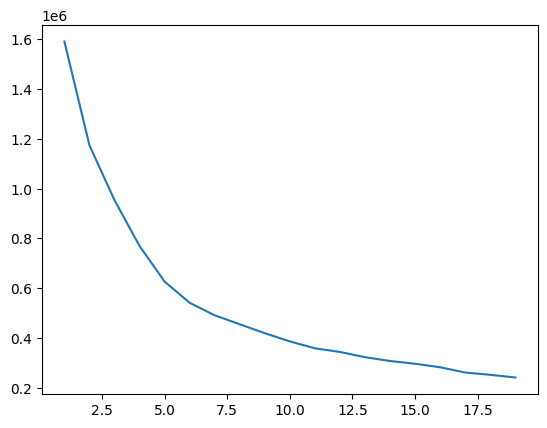

In [45]:
# Determine the best no of clusters using Elbow method
lo_inertia = []
for n_clusters in range(1,20):
    km = KMeans(n_clusters=n_clusters,random_state=42) 
    km.fit(train_pca_df)
    lo_inertia.append(km.inertia_)
    print(n_clusters,km.inertia_)
plt.plot(range(1,20),lo_inertia)

### Best number of clusters based on Elbow method is 10

# K-means Clustering

In [46]:
km = KMeans(n_clusters=10, random_state=42)
train_pca_df['Cluster'] = km.fit_predict(train_pca_df)
test_pca_df['Cluster'] = km.predict(test_pca_df)
test_pca_df.head()

,pca0,pca1,pca2,pca3,Cluster
0,0.684899,-1.325280,-0.671174,-0.799062,3
1,1.811687,1.285494,1.374861,0.883569,7
2,0.252280,0.158402,0.210168,0.978444,4
3,1.155576,-0.812483,1.493726,0.591460,4
4,0.573900,-0.591294,-1.107274,-0.670822,3


# Cluster Profiling

In [51]:
original_df['Description'] = desc
original_df['Country'] = country
original_df['CustomerID'] =  cust_id
train_df['Cluster'] = train_pca_df['Cluster'].values
test_df['Cluster'] = test_pca_df['Cluster'].values
train_df_copy = train_df[['Cluster']]
test_df_copy = test_df[['Cluster']]

In [52]:
train_df_copy = train_df_copy.merge(original_df[['TotalPrice', 'Month', 'Description', 'CustomerID', 'Country','DescriptionFreq','frequency']], left_index=True, right_index=True)
test_df_copy = test_df_copy.merge(original_df[['TotalPrice', 'Month', 'Description', 'CustomerID', 'Country','DescriptionFreq','frequency']], left_index=True, right_index=True)
train_df_copy.head()

,Cluster,TotalPrice,Month,Description,CustomerID,Country,DescriptionFreq,frequency
174821,4,5.00,5,SET OF 4 PANTRY JELLY MOULDS,12836.0,United Kingdom,1111,175
401127,3,19.80,10,SET OF TEA COFFEE SUGAR TINS PANTRY,14911.0,EIRE,509,5903
145883,2,19.80,4,TRADITIONAL KNITTING NANCY,16105.0,United Kingdom,625,13
263675,4,1.65,7,LUNCH BAG DOLLY GIRL DESIGN,18283.0,United Kingdom,706,756
256132,5,25.20,7,NO SINGING METAL SIGN,14918.0,United Kingdom,505,45


In [53]:
# Profiling clusters with training data
def mode_series(series):
    return series.mode()[0] if not series.mode().empty else None

cluster_profiles = train_df_copy.groupby('Cluster').agg({
    'TotalPrice': 'sum',          
    'frequency': 'mean',         
    'Month': mode_series,               
    'DescriptionFreq': 'mean',   
    'Country': lambda x: x.mode()[0], 
    'Description': lambda x: x.mode()[0],
    'CustomerID': lambda x: x.mode()[0]
}).reset_index()

cluster_profiles

,Cluster,TotalPrice,frequency,Month,DescriptionFreq,Country,Description,CustomerID
0,0,353985.533,948.884164,11,235.897696,United Kingdom,WOODEN STAR CHRISTMAS SCANDINAVIAN,17841.00000
1,1,246293.100,135080.000000,1,244.486994,United Kingdom,JUMBO BAG TOYS,15287.69057
2,2,735381.690,1151.130073,3,347.848462,United Kingdom,HOMEMADE JAM SCENTED CANDLES,14911.00000
3,3,932079.890,522.791226,11,340.509148,United Kingdom,JUMBO BAG VINTAGE DOILY,14911.00000
4,4,139053.720,871.038941,11,905.519416,United Kingdom,REX CASH+CARRY JUMBO SHOPPER,17841.00000
5,5,636903.450,20668.498922,11,384.956825,United Kingdom,HAND WARMER OWL DESIGN,15287.69057
6,6,278314.150,135080.000000,12,258.099024,United Kingdom,check,15287.69057
7,7,372380.610,2658.808114,5,1385.283045,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,15287.69057
8,8,104852.450,135080.000000,7,1096.319252,United Kingdom,573585,15287.69057
9,9,250790.900,735.856782,3,283.251423,United Kingdom,COLOUR GLASS T-LIGHT HOLDER HANGING,17841.00000


In [54]:
# Profiling clusters with testing data
def mode_series(series):
    return series.mode()[0] if not series.mode().empty else None

cluster_profiles = test_df_copy.groupby('Cluster').agg({
    'TotalPrice': 'sum',          
    'frequency': 'mean',         
    'Month': mode_series,               
    'DescriptionFreq': 'mean',   
    'Country': lambda x: x.mode()[0], 
    'Description': lambda x: x.mode()[0],
    'CustomerID': lambda x: x.mode()[0]
}).reset_index()

cluster_profiles

,Cluster,TotalPrice,frequency,Month,DescriptionFreq,Country,Description,CustomerID
0,0,89865.920,939.124295,11,237.287123,United Kingdom,WOODEN STAR CHRISTMAS SCANDINAVIAN,17841.00000
1,1,62670.880,135080.000000,1,244.931258,United Kingdom,PICNIC BASKET WICKER SMALL,15287.69057
2,2,181806.570,1167.754425,3,348.954105,United Kingdom,HOME BUILDING BLOCK WORD,14911.00000
3,3,232550.130,504.571788,11,342.068223,United Kingdom,JUMBO BAG VINTAGE DOILY,14911.00000
4,4,34965.080,861.688705,11,910.581122,United Kingdom,REX CASH+CARRY JUMBO SHOPPER,17841.00000
5,5,156324.240,20566.226448,11,385.561819,United Kingdom,CREAM SWEETHEART MINI CHEST,15287.69057
6,6,70084.980,135080.000000,12,255.713427,United Kingdom,check,15287.69057
7,7,91837.320,3042.938776,9,1392.666397,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,15287.69057
8,8,25945.710,135080.000000,7,1090.826947,United Kingdom,573585,15287.69057
9,9,61880.891,750.501092,3,284.819490,United Kingdom,PACK OF 20 NAPKINS PANTRY DESIGN,17841.00000


# Visualization

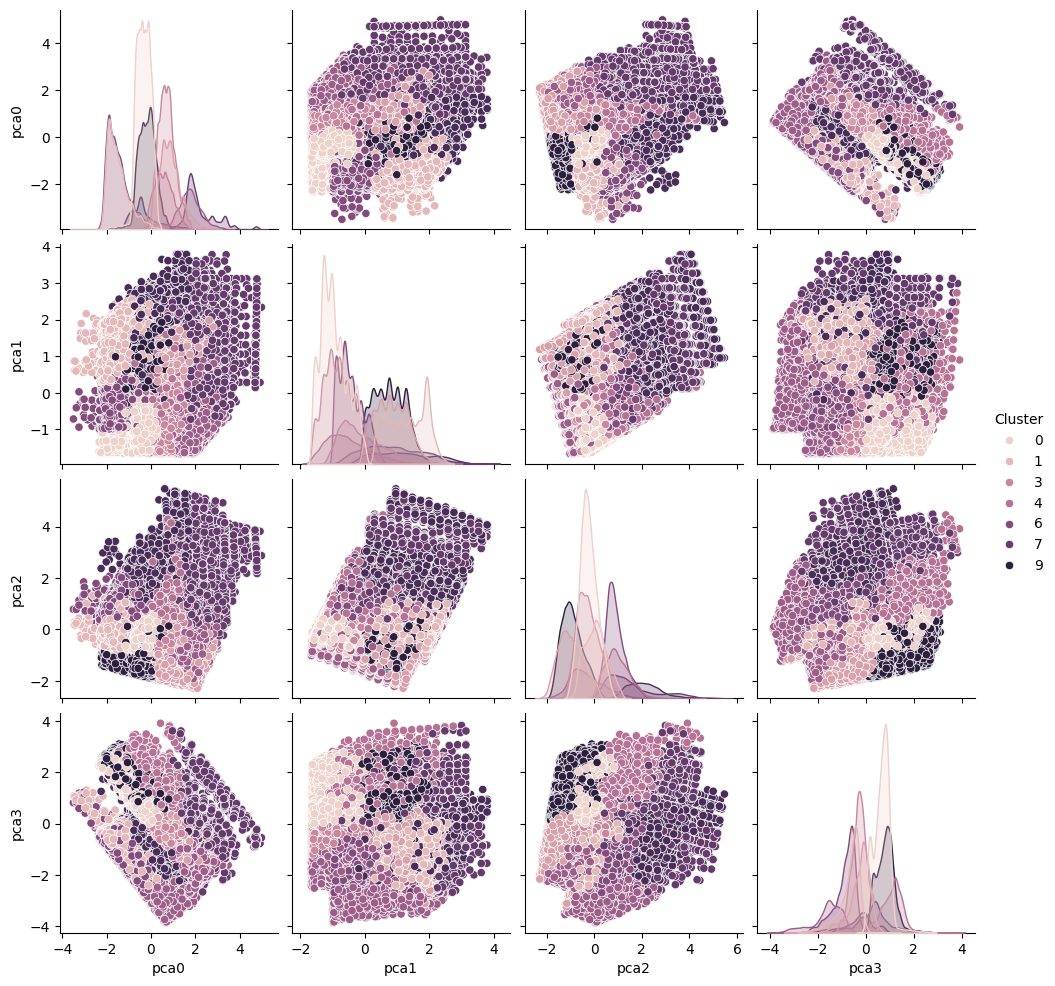

In [56]:
# Visulaize train clusters
sns.pairplot(train_pca_df,hue='Cluster')

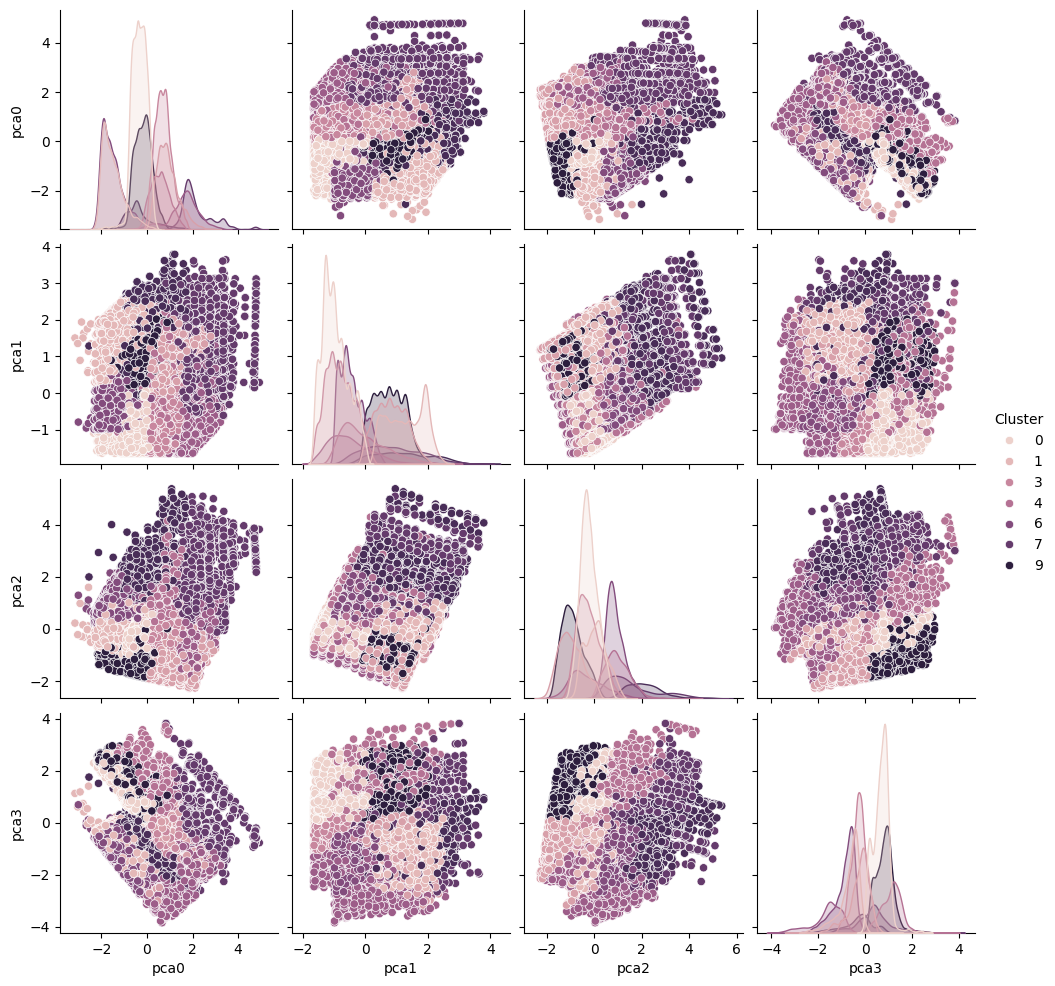

In [57]:
# Visulaize test clusters
sns.pairplot(test_pca_df,hue='Cluster')

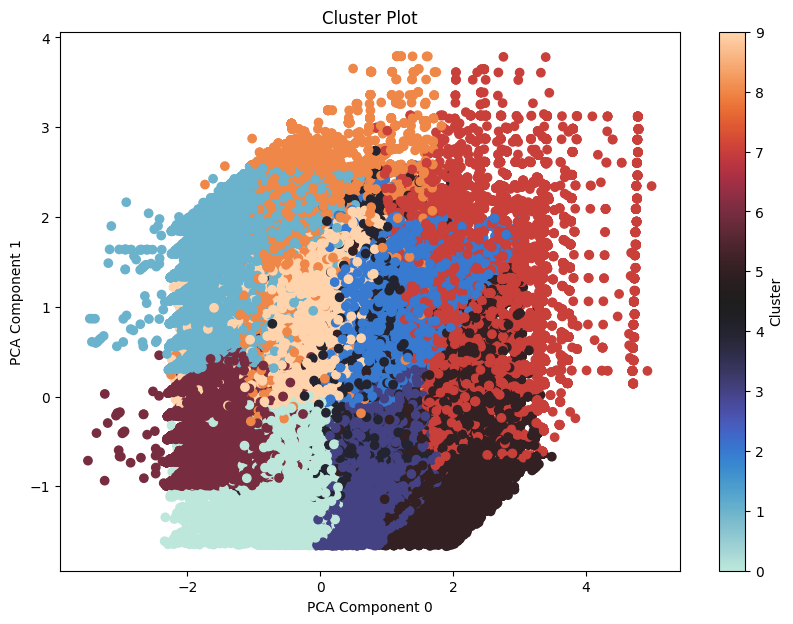

In [60]:
x = train_pca_df['pca0'] 
y = train_pca_df['pca1']

clusters = train_pca_df['Cluster']

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=clusters, cmap='icefire')

plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('Cluster Plot')
plt.colorbar(label='Cluster')
plt.show()

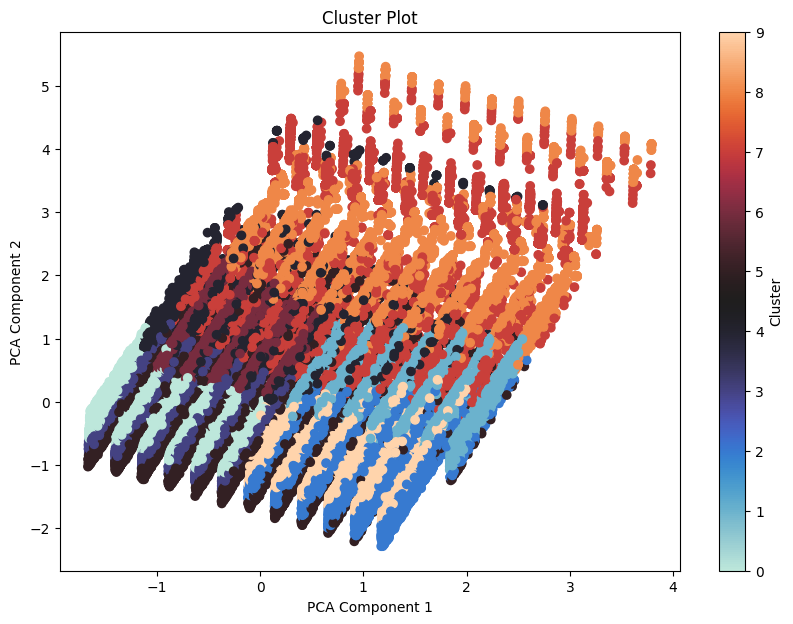

In [61]:
x = train_pca_df['pca1'] 
y = train_pca_df['pca2']

clusters = train_pca_df['Cluster']

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=clusters, cmap='icefire')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Plot')
plt.colorbar(label='Cluster')
plt.show()

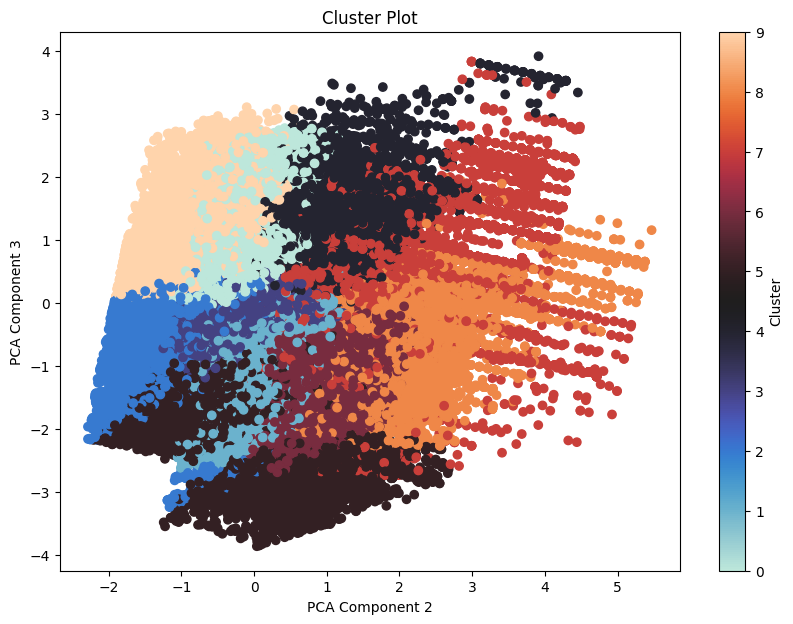

In [62]:
x = train_pca_df['pca2'] 
y = train_pca_df['pca3']

clusters = train_pca_df['Cluster']

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=clusters, cmap='icefire')

plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.title('Cluster Plot')
plt.colorbar(label='Cluster')
plt.show()

# Evaluation

In [58]:
# within-cluster sum of squares (WCSS). 
km.inertia_

387540.3688622736

In [63]:
# silhouette score
silhouette_avg_test = silhouette_score(test_pca_df, test_pca_df['Cluster'])
print(f"Silhouette Score for test data: {silhouette_avg_test}")

Silhouette Score for test data: 0.5755174500254299


# Personalization Recommendations, Interpretation and Insights

### We have 10 main groups of customers and here we will discuss the appropiate recommendations for each based on the training data as it more general (But nearly all the features are same)

#### For Group 0:
##### The product WOODEN STAR CHRISTMAS SCANDINAVIAN should be present in enough quantitis (236 at least) especially in United Kingdom and in November, also showing ads to the customer whose id is 17841.0 can increase the sales

#### For Group 1:
##### The product JUMBO BAG TOYS should be present in enough quantitis (255 at least) especially in United Kingdom and in January, also showing ads to the customer whose id is 15287.69057 can increase the sales

#### For Group 2:
##### The product HOMEMADE JAM SCENTED CANDLES should be present in enough quantitis (348 at least) especially in United Kingdom and in March, also showing ads to the customer whose id is 14911.00000 can increase the sales

#### For Group 3:
##### The product JUMBO BAG VINTAGE DOILY should be present in enough quantitis (341 at least) especially in United Kingdom and in November, also showing ads to the customer whose id is 14911.00000 can increase the sales

#### For Group 4:
##### The product REX CASH+CARRY JUMBO SHOPPER should be present in enough quantitis (911 at least) especially in United Kingdom and in November, also showing ads to the customer whose id is 17841.0 can increase the sales

#### For Group 5:
##### The product HAND WARMER OWL DESIGN should be present in enough quantitis (385 at least) especially in United Kingdom and in November, also showing ads to the customer whose id is 15287.69057 can increase the sales

#### For Group 6:
##### The product check	should be present in enough quantitis (259 at least) especially in United Kingdom and in December, also showing ads to the customer whose id is 15287.69057  can increase the sales

#### For Group 7:
##### The product WHITE HANGING HEART T-LIGHT HOLDER should be present in enough quantitis (1386 at least) especially in United Kingdom and in May, also showing ads to the customer whose id is 15287.69057 can increase the sales

#### For Group 8:
##### The product 573585 should be present in enough quantitis (1097 at least) especially in United Kingdom and in July, also showing ads to the customer whose id is 15287.69057 can increase the sales

#### For Group 9:
##### The product COLOUR GLASS T-LIGHT HOLDER HANGING should be present in enough quantitis (284 at least) especially in United Kingdom and in March, also showing ads to the customer whose id is 17841.0 can increase the sales

### Paying more attention to groups 2,3, and 5 should increase sales significantly as their total prices are highest among all other groups

### Store most of products in UK as it is the most country in revenue